In [1]:
##This is a pytorch implement for HybridSN 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import spectral
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from scipy.io import loadmat
import os
from tqdm import tqdm
%matplotlib inline

In [2]:
##hypeperameters and experimental settings
RANDOM_SEED=666
DATASET = 'IP'    ## PU  IP  SA  
TRAIN_RATE = 0.3  ## ratio of training data
VAL_RATE = 0.1    ## ratio of valuating data
EPOCH = 100    ##number of epoch
VAL_EPOCH = 5  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 256
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components
PATCH_SIZE = 25 
SAVE_PATH = f"results\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)

In [3]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'dataset')
    if name == 'IP':
        data = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_gt.mat'))['indian_pines_gt']
        class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill","Corn", "Grass-pasture", 
                       "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats","Soybean-notill", "Soybean-mintill", "Soybean-clean","Wheat", "Woods", "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
    elif name == 'SA':
        data = loadmat(os.path.join(data_path, 'Salinas\\Salinas_corrected.mat'))['salinas_corrected']
        labels = loadmat(os.path.join(data_path, 'Salinas\\Salinas_gt.mat'))['salinas_gt']
        class_name = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow',
                        'Fallow_rough_plow','Fallow_smooth','Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green','Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk','Vinyard_untrained','Vinyard_vertical']
    elif name == 'PU':
        data = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU.mat'))['paviaU']
        labels = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU_gt.mat'))['paviaU_gt']
        class_name = ['Asphalt', 'Meadows', 'Gravel', 'Trees','Painted metal sheets', 'Bare Soil', 
                      'Bitumen','Self-Blocking Bricks', 'Shadows']
    return data, labels, class_name


In [5]:
data,label,class_name = loadData(DATASET)
NUM_CLASS = label.max()

c:\Users\Sendfor\PyWORKSPACE\stu_torch\venv\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


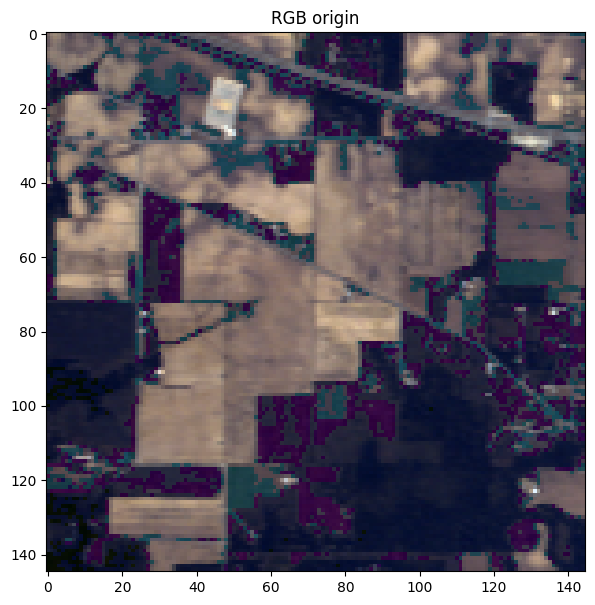

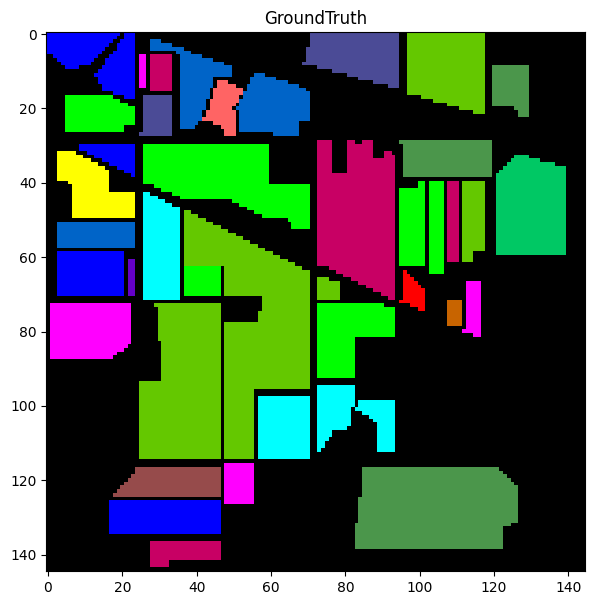

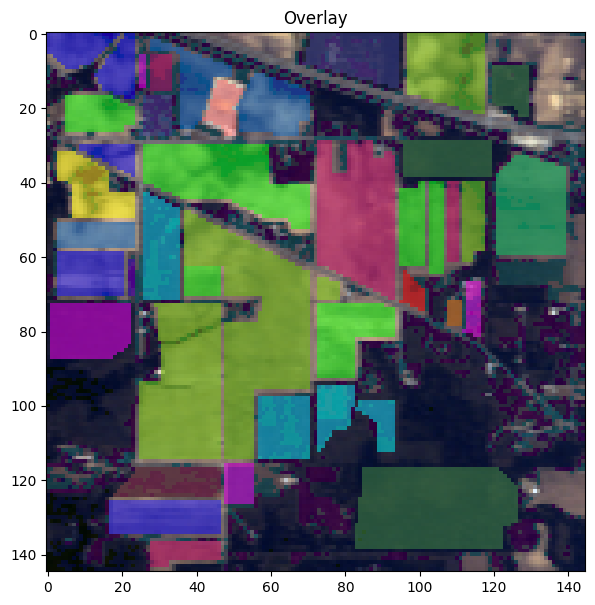

In [6]:
## display HSI
rgb_view=spectral.imshow(data,(30,20,10),classes=label,title='RGB origin',figsize=(7,7))
gt_view = spectral.imshow(classes=label, title='GroundTruth',figsize=(7,7))
view = spectral.imshow(data,(30,20,10),classes=label,figsize=(7,7))
view.set_display_mode('overlay')
view.class_alpha = 0.5
view.set_title('Overlay')
spectral.save_rgb(f'results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [7]:
## show 3D cube
# %matplotlib auto
# spectral.view_cube(data,(30,20,10))   ## depend on wxpython and pyopengl

In [8]:
def applyPCA(X, numComponents=15):
    """PCA processing

    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional): number of reserved components. Defaults to 15.

    Returns:
        newX: _description_
    """
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)   ##PCA and normalization
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [9]:
data,pca = applyPCA(data,N_PCA)
data.shape

(145, 145, 15)

In [10]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    print(gt)
    print('--------------------------------------')
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...]) 获取非零元素的行索引和列索引
    print(indices)
    print('--------------------------------------')
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels 定位到各元素的坐标
    y = gt[indices].ravel()  #  获取对应于非零索引的类图值，并将其展平
    print(y)
    print(y.max())
    print('--------------------------------------')
    
    train_gt = np.zeros_like(gt)  # 创建一个与gt形状相同，但元素全为零的数组，用于存储训练类图
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    print(train_indices)
    print('以上为train_indices --------------------------------------')
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]] 
    test_indices = [t for t in zip(*test_indices)]   # 将测试索引转换为[[x1,x2,...],[y1,y2,...]]的格式。一次性访问多个元素
    print(train_indices)
    print('以上为train_indices --------------------------------------')
    print(tuple(train_indices))
    print('以上为tuple(train_indices)------')
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    print(gt[tuple(train_indices)])
    print('以上为gt[tuple(train_indices)]------')
    print(train_gt)
    print('以上为train_gt--------------------------------------')
    
    return train_gt, test_gt

In [11]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

[[3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
--------------------------------------
(array([  0,   0,   0, ..., 143, 143, 143], dtype=int64), array([ 0,  1,  2, ..., 30, 31, 32], dtype=int64))
--------------------------------------
[ 3  3  3 ... 10 10 10]
16
--------------------------------------
[(37, 8), (41, 129), (125, 120), (38, 100), (60, 79), (24, 28), (71, 114), (105, 65), (54, 29), (7, 77), (127, 93), (81, 10), (117, 48), (66, 50), (43, 83), (92, 34), (69, 115), (5, 108), (78, 60), (14, 123), (128, 46), (40, 100), (20, 48), (94, 42), (90, 52), (59, 42), (62, 9), (86, 13), (43, 70), (134, 31), (52, 92), (37, 54), (68, 88), (5, 19), (106, 41), (48, 95), (75, 57), (65, 27), (38, 108), (64, 30), (61, 11), (44, 109), (122, 104), (74, 88), (34, 75), (20, 129), (56, 104), (0, 21), (1, 100), (67, 58), (3, 80), (57, 34), (35, 58), (73, 43), (42, 85), (76, 79), (91, 82), (4, 93), (105, 50), (95, 81), (111, 36), (

  class   train_num  val_num   test_num   total   
    1         14        5         27        46    
    2        428       143       857       1428   
    3        249        83       498       830    
    4         71        24       142       237    
    5        145        48       290       483    
    6        219        73       438       730    
    7         8         3         17        28    
    8        143        48       287       478    
    9         6         2         12        20    
    10       292        97       583       972    
    11       736       245       1474      2455   
    12       178        59       356       593    
    13        62        20       123       205    
    14       379       127       759       1265   
    15       116        39       231       386    
    16        28        9         56        93    
  total      3074      1025      6150     10249   


c:\Users\Sendfor\PyWORKSPACE\stu_torch\venv\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Interpolation       :  <default>

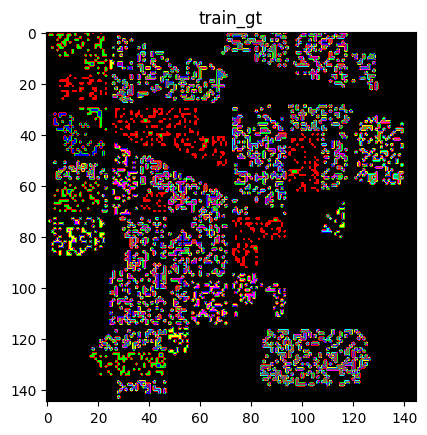

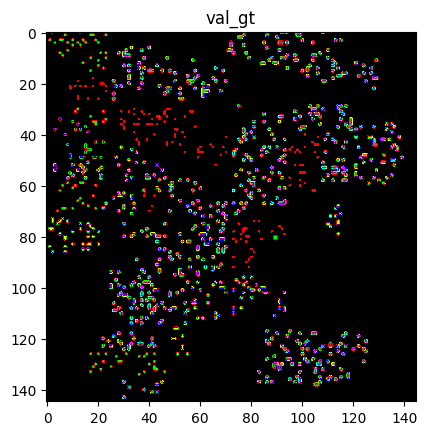

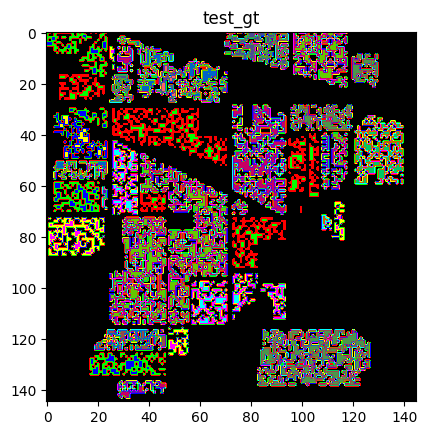

In [12]:
## display sampling info
sample_report = f"{'class': ^10}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{i: ^10}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^10}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
spectral.imshow(classes=train_gt, title='train_gt')
spectral.imshow(classes=val_gt, title='val_gt')
spectral.imshow(classes=test_gt, title='test_gt')

In [13]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 

        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label


In [14]:
##create dataset and dataloader
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, label, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [15]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 25, 25]), tensor(2))

In [16]:
## Defination of HybridSN
class HybridSN(nn.Module):
    def __init__(self, in_chs, patch_size, class_nums):
        super().__init__()
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.conv1 = nn.Sequential(
                    nn.Conv3d(in_channels=1,out_channels=8,kernel_size=(7, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
                    nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(
                    nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3, 3, 3)),
                    nn.ReLU(inplace=True))
        
        self.x1_shape = self.get_shape_after_3dconv()
        # print(self.x1_shape)
        self.conv4 = nn.Sequential(
                    nn.Conv2d(in_channels=self.x1_shape[1]*self.x1_shape[2],out_channels=64,kernel_size=(3, 3)),
                    nn.ReLU(inplace=True))
        self.x2_shape = self.get_shape_after_2dconv()
        # print(self.x2_shape)
        self.dense1 = nn.Sequential(
                    nn.Linear(self.x2_shape,256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense2 = nn.Sequential(
                    nn.Linear(256,128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense3 = nn.Sequential(
                    nn.Linear(128,class_nums)
                   )
    
    def get_shape_after_2dconv(self):
        x = torch.zeros((1, self.x1_shape[1]*self.x1_shape[2], self.x1_shape[3], self.x1_shape[4]))
        with torch.no_grad():
            x = self.conv4(x)
            print
        return x.shape[1]*x.shape[2]*x.shape[3]
    
    def get_shape_after_3dconv(self):
        x = torch.zeros((1, 1, self.in_chs, self.patch_size, self.patch_size))
        with torch.no_grad():
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.shape
    
    def forward(self, X):
        X = X.unsqueeze(1)
        x = self.conv1(X)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2],x.shape[3],x.shape[4])
        # print(x.shape)
        x = self.conv4(x)
        x = x.contiguous().view(x.shape[0], -1)
        # print(x.shape)
        x = self.dense1(x)
        x = self.dense2(x)
        out = self.dense3(x)
        return out


net = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
summary(net, input_size=(1,N_PCA,PATCH_SIZE,PATCH_SIZE),col_names=['num_params','kernel_size','mult_adds','input_size','output_size'],col_width=10,row_settings=['var_names'],depth=4)

Layer (type (var_name))                  Param #    Kernel Shape Mult-Adds  Input Shape Output Shape
HybridSN (HybridSN)                      --         --         --         [1, 15, 25, 25] [1, 16]
├─Sequential (conv1)                     --         --         --         [1, 1, 15, 25, 25] [1, 8, 9, 23, 23]
│    └─Conv3d (0)                        512        [7, 3, 3]  2,437,632  [1, 1, 15, 25, 25] [1, 8, 9, 23, 23]
│    └─ReLU (1)                          --         --         --         [1, 8, 9, 23, 23] [1, 8, 9, 23, 23]
├─Sequential (conv2)                     --         --         --         [1, 8, 9, 23, 23] [1, 16, 5, 21, 21]
│    └─Conv3d (0)                        5,776      [5, 3, 3]  12,736,080 [1, 8, 9, 23, 23] [1, 16, 5, 21, 21]
│    └─ReLU (1)                          --         --         --         [1, 16, 5, 21, 21] [1, 16, 5, 21, 21]
├─Sequential (conv3)                     --         --         --         [1, 16, 5, 21, 21] [1, 32, 3, 19, 19]
│    └─Conv3d (0)      

Training::   1%|          | 1/100 [00:09<15:05,  9.15s/it]

epoch 0/100 loss:0.010744667239365985  acc:0.1841249186727391


Training::   2%|▏         | 2/100 [00:16<13:17,  8.13s/it]

epoch 1/100 loss:0.00944527217763232  acc:0.2648015614834092


Training::   3%|▎         | 3/100 [00:24<12:49,  7.93s/it]

epoch 2/100 loss:0.007584972201653247  acc:0.41899804814573843


Training::   4%|▍         | 4/100 [00:31<12:24,  7.75s/it]

epoch 3/100 loss:0.006409779297661766  acc:0.4703968770331815


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


epoch 4/100 loss:0.006141481650829625  acc:0.5117111255692909


Training::   5%|▌         | 5/100 [00:39<12:15,  7.74s/it]

epoch 4/100  val_acc:0.6302439024390244


Training::   6%|▌         | 6/100 [00:47<12:09,  7.76s/it]

epoch 5/100 loss:0.0041109006396702645  acc:0.6203643461288224


Training::   7%|▋         | 7/100 [00:54<11:37,  7.50s/it]

epoch 6/100 loss:0.0032304959612848238  acc:0.7042940793754067


Training::   8%|▊         | 8/100 [01:01<11:11,  7.30s/it]

epoch 7/100 loss:0.0023260174422763003  acc:0.7885491216655823


Training::   9%|▉         | 9/100 [01:10<11:59,  7.91s/it]

epoch 8/100 loss:0.0017424273215568757  acc:0.8610930383864671


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


epoch 9/100 loss:0.001357556059568752  acc:0.8806115810019518


Training::  10%|█         | 10/100 [01:19<12:19,  8.22s/it]

epoch 9/100  val_acc:0.9473170731707317


Training::  11%|█         | 11/100 [01:26<11:39,  7.86s/it]

epoch 10/100 loss:0.0009388248730031561  acc:0.9258295380611581


Training::  12%|█▏        | 12/100 [01:34<11:40,  7.96s/it]

epoch 11/100 loss:0.0007331782639346396  acc:0.9339622641509434


Training::  13%|█▎        | 13/100 [01:42<11:29,  7.92s/it]

epoch 12/100 loss:0.000572601604719556  acc:0.9567338972023423


Training::  14%|█▍        | 14/100 [01:50<11:25,  7.97s/it]

epoch 13/100 loss:0.0003872079897136291  acc:0.9733246584255042


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


epoch 14/100 loss:0.00043226094406265364  acc:0.968445022771633


Training::  15%|█▌        | 15/100 [01:59<11:41,  8.26s/it]

epoch 14/100  val_acc:0.9921951219512195


Training::  16%|█▌        | 16/100 [02:07<11:20,  8.10s/it]

epoch 15/100 loss:0.00028484552036085807  acc:0.9756018217306441


Training::  17%|█▋        | 17/100 [02:15<11:30,  8.32s/it]

epoch 16/100 loss:0.0001817548340919647  acc:0.9886141834743006


Training::  18%|█▊        | 18/100 [02:24<11:39,  8.53s/it]

epoch 17/100 loss:0.00017878643940545246  acc:0.9876382563435263


Training::  18%|█▊        | 18/100 [02:28<11:18,  8.27s/it]


Stop in epoch 18


KeyboardInterrupt: 

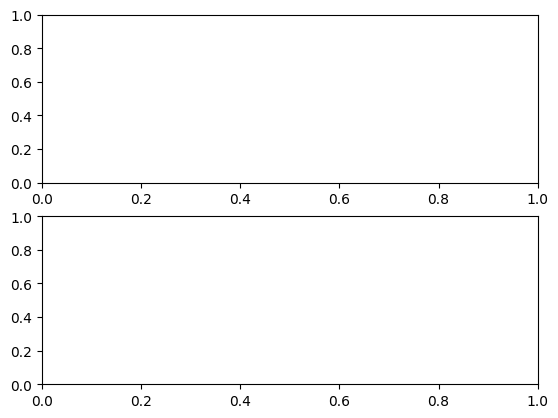

: 

In [17]:
## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []

model = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        model.train()
        avg_loss = 0.
        train_acc = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            val_acc =0
            model.eval()
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            torch.save(model.state_dict(),save_name)
    ax1.plot(np.arange(e+1),loss_list)
    ax1.set_title('loss')
    ax1.set_xlabel('epoch')
    ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
    ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
    ax2.set_title('acc')
    ax2.set_xlabel('epoch')
    ax2.legend()
except Exception as exc:
    print(exc)
finally: 
    print(f'Stop in epoch {e}')


In [ ]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    """get best model path by valuation list

    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir

    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

In [ ]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH)
best_model = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path))
## inference
best_model.to(device)
best_model.eval()
pred_map = []
for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    data = data.to(device)
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(label.shape[0],label.shape[1])
spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
spectral.imshow(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction_masked.jpg"),pred_map*(label!=0),colors = spectral.spy_colors)

In [ ]:
## classfication report
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'classfication_report.txt'),'w+')
fp.writelines(report_log)
fp.close()